# Integration of genetic determinants and GSM: metabolites biosynthesis

In [1]:
import cobra
import re
import json
import sys
import os
from cameo import models
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from scipy import stats

### Load model from bigg database using CAMEO

In [2]:
m = models.bigg.iML1515

# gene dictionaries for mapping between ID and names
gene_name_dic = {}
for g in m.genes:
    gene_name_dic[g.name] = g.id
    
gene_name_dic2 = {}
for g in m.genes:
    gene_name_dic2[g.id] = g.name

### Load genetic determinants

In [4]:
df_AB_all = pd.read_pickle('Data/GSMGeneticDeterminants_bothdir.pkl')
genes_ALL = list(df_AB_all.index)

# 1. Compute metabolite yields - or just load results below

In [ ]:


# turn off biomass as objective function
m.reactions.BIOMASS_Ec_iML1515_core_75p37M.objective_coefficient = 0.0

metabolites = []
for met in m.metabolites:
    metabolites.append(met.id)
    
# calculate for wild type
wt_yields = {}
with m:
    for met in metabolites:
        #print(met)
        dm_id = str(met) + '_dummy_drain'
        DM_met = Reaction(dm_id)
        DM_met.name = met + ' dummy drain'
        DM_met.lower_bound = 0.0
        DM_met.upper_bound = 0.0
        DM_met.add_metabolites({m.metabolites.get_by_id(met) : -1.0})
        m.add_reactions([DM_met])

        m.reactions.get_by_id(dm_id).bounds = (0.0, 1000.0)
        m.objective = m.reactions.get_by_id(dm_id)           
        # set direction
        m.objective_direction = 'max'
        try:
            sol = m.optimize()
            #print(sol[dm_id])
            if sol.status == 'optimal':
                if sol[dm_id] > 0.00001:
                    wt_yields[dm_id] = sol[dm_id]
                else:
                    wt_yields[dm_id] = 0.0

            else:
                wt_yields[dm_id] = 0.0
        except:
            wt_yields[dm_id] = 0.0



# repeat for all the genetic determinants
MetYields_all = pd.DataFrame(index = metabolites)
MetYields_all.insert(0, column = 'wt', value = wt_yields.values())

MetYields_changes_all = pd.DataFrame(index = metabolites)
MetYields_changes_all.insert(0, column = 'wt', value = [1]*len(wt_yields.keys()))

count = 1
for gene in genes_ALL:

    ko_yields = []
    ko_changes = []
    with m:
        m.genes.get_by_id(gene.id).knock_out()
        for met in metabolites:
            
            # add drain reaction for metabolite
            dm_id = str(met) + '_dummy_drain'
            DM_met = Reaction(dm_id)
            DM_met.name = met + ' dummy drain'
            DM_met.lower_bound = 0.0
            DM_met.upper_bound = 0.0
            DM_met.add_metabolites({m.metabolites.get_by_id(met) : -1.0})
            m.add_reactions([DM_met])

            m.reactions.get_by_id(dm_id).bounds = (0.0, 1000.0)
            m.objective = m.reactions.get_by_id(dm_id)   # set the maximisation of metabolite production flux as objective        
            # set direction
            m.objective_direction = 'max'
            try:
                sol = m.optimize()
                if sol.status == 'optimal':
                    if sol[dm_id] > 0.00001:
                        ko_yields.append(sol[dm_id])
                        ko_changes.append(sol[dm_id]/wt_yields[dm_id])
                    else:
                        ko_yields.append(0.0)
                        ko_changes.append(0.0)
                else:
                    ko_yields.append(0.0)
                    ko_changes.append(0.0)
            except:
                ko_yields.append(0.0)
                ko_changes.append(0.0)
    MetYields_all.insert(count, column = gene.id, value = ko_yields) # add the yields of metabolites to dataframe
    MetYields_changes_all.insert(count, column = gene.id, value = ko_changes) # add change in metabolite yield compared to WT metabolite yield
    count += 1


#MetYields_all.to_pickle('MetYields.pkl', protocol = 2)
#MetYields_changes_all.to_pickle('MetYields_changes.pkl', protocol = 2)

### Load the metabolite yields (on glucose)

In [5]:
MetYields = pd.read_pickle('Data/MetYields_ALL.pkl')

In [6]:
# get the metabolite yields for just the genes in our list
MetYields289 = pd.DataFrame(index = MetYields.index)
count = 0
MetYields289.insert(0, column = 'wt', value = list(MetYields['wt'].values))
for ind, i in enumerate(MetYields.columns):
    if i in genes_ALL:
        count += 1
        MetYields289.insert(count, column = i, value = list(MetYields[i].values))

# 2. Network analysis of the results

In [7]:
edges = []
for ind, g in enumerate(MetYields289.columns):
    if g != 'wt':
        for ind_met, met in enumerate(MetYields289.index):
            if MetYields289['wt'][ind_met] > 0.0001:
                if MetYields289[g][ind_met]/MetYields289['wt'][ind_met] < 0.00001:
                        
                    if '_c' in met:
                        met_new = met.split('_c')[0]
                    elif '_e' in met:
                        met_new = met.split('_e')[0]
                    elif '_p' in met:
                        met_new = met.split('_p')[0]
                    #if (m.genes.get_by_id(g).name, met_new) not in edges:
                    edges.append((m.genes.get_by_id(g).name, met_new))


# turn into graph
nodes1 = []
nodes2 = []
for edge in edges:
    nodes1.append(edge[0])
    nodes2.append(edge[1])         
nodes1 = list(set(nodes1))
nodes2 = list(set(nodes2))

G = nx.Graph()
G.add_nodes_from(nodes1+nodes2)
G.add_edges_from(edges)

In [8]:
print('Number of gene nodes:', len(nodes1))
print('Number of metabolite nodes:', len(nodes2))

Number of gene nodes: 98
Number of metabolite nodes: 508


### Run the greedy algorithm for clustering the genes and metabolites in networkx

In [9]:
c = list(greedy_modularity_communities(G))

In [10]:
# add labels to the nodes
gene_name_dic3 = {}
for g in m.genes:
    gene_name_dic3[g.name] = g.name
nx.set_node_attributes(G, gene_name_dic3, name = 'labels')


# colour code each metabolite in the network according to the cluster they have been assigned to
for met in nodes2:
    for ind, cluster in enumerate(c):
        if met in c[ind]:
            G.add_node(met, color = str(ind))

for gene in nodes1:
    for ind, cluster in enumerate(c):
        if gene in c[ind]:
            G.add_node(gene, color = str(ind))
                

                
# Save the network
#nx.write_gml(G, 'Bipartite_MetaboliteYields_bothdir.gml')

# 3. Enrichment of metabolic pathways in the network clusters

### significant pathways from 40 pathways in model

In [11]:
def create_met_reacs_dataframe(nodes2, m):
    met_reacs = {}
    for i in nodes2:        
        if i + '_c' in m.metabolites:
            met_name = i + '_c'
            col = {}
            for r in m.reactions:
                if r in m.metabolites.get_by_id(met_name).reactions:
                    col[r.id] = 1
                else:
                    col[r.id] = 0
            met_reacs[i] = col
                
        elif i + '_p' in m.metabolites:
            met_name = i + '_p'
            col = {}
            for r in m.reactions:
                if r in m.metabolites.get_by_id(met_name).reactions:
                    col[r.id] = 1
                else:
                    col[r.id] = 0
            met_reacs[i] = col
            
            
                    
        
    df_met_reacs = pd.DataFrame.from_dict(met_reacs)
    
    return met_reacs, df_met_reacs

In [50]:
# dataframe of reactions (all in model) vs. subsystems

In [12]:
subsystems = []
for s in m.reactions:
    subsystems.append(s.subsystem)
subsystems = list(set(subsystems))  


reacs = []
for r in m.reactions:
    reacs.append(r.id)
df_reacs_sss_all = pd.DataFrame(index = reacs)

count = 0
for s in subsystems:
 
    s_genes = []
    for r in m.reactions:
        r_s = 0        
        if r.subsystem in s:

            r_s = 1
        s_genes.append(r_s)
    
    df_reacs_sss_all.insert(count, column = s, value = s_genes)
    count += 1

In [54]:
# Dataframe of metabolites vs. subsystems

In [13]:
metabolites = []
for i in m.metabolites:
    if '_c' in i.id:
        met_id = i.id.split('_c')[0]
    elif '_e' in i.id:
        met_id = i.id.split('_e')[0]
    elif '_p' in i.id:
        met_id = i.id.split('_p')[0]
    metabolites.append(met_id)
metabolites = list(set(metabolites))   

# get the number of reactions associated to each cluster for each metabolic system
met_reacs, df_met_reacs = create_met_reacs_dataframe(metabolites, m)
df_met_sss = df_met_reacs.T.dot(df_reacs_sss_all)
df_met_sss[df_met_sss> 0] = 1

In [170]:
# Get significant pathways in each cluster if cluster larger than 10 nodes

In [14]:
sig_pathways_clusters40 = {}
for ind, cluster_id in enumerate(c):
    genes = []
    genes_pathway = {}
    if len(c[ind]) > 10.0:
        print('')
        print(ind)
        nodes_list = []
        for i in c[ind]:
            if i in nodes2:
                nodes_list.append(i)


        met_reacs, df_met_reacs_c = create_met_reacs_dataframe(nodes_list, m)
        df_met_sss_c = df_met_reacs_c.T.dot(df_reacs_sss_all)
        df_met_sss_c[df_met_sss_c> 0] = 1


        p_value = []
        p_val_name = []
        for s in subsystems:
            x = df_met_sss_c.sum(axis = 0)[s]
            M = df_met_sss.sum(axis = 0)[s] # from all metabolites in the model
            if M != 0.0 and x != 0.0:
                p = stats.hypergeom.sf(x, len(metabolites), M, len(nodes_list))
            else:
                p = 1.0
                
            genes_path = []
            for ind_met, met in enumerate(df_met_sss_c[s]):
                if met > 0:
                    metabolite = df_met_sss_c.index[ind_met]
                    genes = G.neighbors(metabolite)
                    for ge in genes:
                        if ge in c[ind]:
                            genes_path.append(ge)
            genes_pathway[s] = list(set(genes_path))


                #if p < 0.05:
                #    print(ind, ss, x, M, p)


            p_value.append(p)
            p_val_name.append(s)
        print('')       
        print('corrected significance:')       


        from operator import itemgetter
        indices, pval_sorted = zip(*sorted(enumerate(p_value), key=itemgetter(1)))
        sig_pathways_clusters40[ind] = {}
        sig_pathways = []
        for indj, i in enumerate(pval_sorted):
            if i < ((indj+1)/40)*0.01:
                #print(p_val_name[indices[ind]], i, ((ind+1)/40)*0.01)
                sig_pathways.append(p_val_name[indices[indj]])
                sig_pathways_clusters40[ind].update({p_val_name[indices[indj]] : genes_pathway[p_val_name[indices[indj]]]})
                print(p_val_name[indices[indj]], i, ((ind+1)/40)*0.01)
                print(genes_pathway[p_val_name[indices[indj]]])
        if sig_pathways == []:
                sig_pathways_clusters40[ind] = {}


0

corrected significance:
Membrane Lipid Metabolism 1.805582736188005e-28 0.00025
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM', 'ribC']
Nucleotide Salvage Pathway 2.649392765143667e-13 0.00025
['purL', 'folP', 'purA', 'pncB', 'purD', 'purM', 'nepI', 'yjjX', 'rdgB']
Histidine Metabolism 8.35234198891111e-08 0.00025
['purL', 'hisF', 'hisC', 'aroP', 'hisI', 'purA', 'purD', 'purM', 'hisB', 'hisH', 'hisA', 'hisD', 'hisG']
Folate Metabolism 1.558555720668077e-07 0.00025
['purL', 'folP', 'purA', 'purD', 'purM']
Purine and Pyrimidine Biosynthesis 2.9396138791942903e-07 0.00025
['purL', 'folP', 'purA', 'purD', 'purM']
Metabolite Repair 2.0750887507030296e-06 0.00025
['purM', 'purL', 'purA', 'purD']
Valine, Leucine, and Isoleucine Metabolism 9.375635680619692e-06 0.00025
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM']
Cofactor and Prosthetic Group Biosynthesis 0.00011024036432684796 0.00025
['purL', 'panD', 'folP', 'purA', 'pncB', 'purD', 'ilvD', 'purM', 'citG', 'ribC', 'queD']
Nitrogen Me

### Significance of pathways from finer grained pathways (Biocyc database)

In [15]:
met_pathways = pd.read_excel('Data/Met_Pathways1.xlsx', sheet_name='Sheet1')
met_pathways2 = pd.read_excel('Data/Met_Pathways1.xlsx', sheet_name='Sheet2')



In [16]:
metabolite_pathways = {}
for i in m.metabolites:
    pathways = []
    if 'biocyc' in i.annotation:
        for ind, met in enumerate(met_pathways['Metabolite name']):
            if i.annotation['biocyc'][0].split('META:')[1] == met:
                #print(i, met_pathways2['Pathways of compound'][ind])
                if str(met_pathways2['Pathways of compound'][ind]) != 'nan':
                    pathways = met_pathways2['Pathways of compound'][ind].split(' // ')
    metabolite_pathways[i.id] = pathways

In [17]:
pathways = []
for i, j in metabolite_pathways.items():
    for path in j:
        pathways.append(path)
        
pathways = list(set(pathways))
len(pathways)

436

In [18]:
sig_pathways_clusters = {}
for ind, cluster in enumerate(c):
    if len(c[ind]) > 10:
        print(ind)
        p_value = []
        p_val_name = []
        genes_pathway = {}
        for i in pathways:
            number_mets_ml = 0.0
            number_mets_model = 0.0
            genes_path = []
            for met, j in metabolite_pathways.items():
                for path in j:
                    if i == path:
                        met_id = met.split('_')[0]
                        if met_id in c[ind]:
                            number_mets_ml += 1.0
                            for ge in nodes1:
                                if (ge, met_id) in edges:
                                    if ge in c[ind]:
                                        genes_path.append(ge)

                        if met_id in metabolites:
                            number_mets_model += 1.0


            l_c = 0.0
            for met in c[ind]:
                if met in nodes2:
                    l_c += 1.0
            if number_mets_ml > 3.0:
                p = stats.hypergeom.sf(number_mets_ml, len(metabolites), number_mets_model, l_c)
                #if p < 0.05:
                #    print(i, p, number_mets_ml, number_mets_model)

                p_value.append(p)
                p_val_name.append(i)
                genes_pathway[i] = list(set(genes_path))
                #print(set(genes_path))

            #else:
            #    p_value.append(1.0)
            #    p_val_name.append(i)


        print('')       
        print('corrected significance:')       

        sig_pathways_clusters[ind] = {}
        from operator import itemgetter
        indices, pval_sorted = zip(*sorted(enumerate(p_value), key=itemgetter(1)))
        sig_pathways = []
        for indj, i in enumerate(pval_sorted):
            if i < ((indj+1)/436)*0.01:
                print(p_val_name[indices[indj]], ((indj+1)/396)*0.01)
                #print(((indj+1)/396)*0.01)
                sig_pathways_clusters[ind].update({p_val_name[indices[indj]] : genes_pathway[p_val_name[indices[indj]]]})
                print(genes_pathway[p_val_name[indices[indj]]])

0

corrected significance:
fatty acid &beta;-oxidation I (generic) 2.5252525252525256e-05
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM']
superpathway of purine nucleotides <i>de novo</i> biosynthesis II 5.050505050505051e-05
['purL', 'folP', 'purA', 'purD', 'purM']
oleate &beta;-oxidation 7.575757575757576e-05
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM']
purine ribonucleosides degradation 0.00010101010101010102
['purL', 'purA', 'purD', 'purM', 'nepI']
superpathway of histidine, purine, and pyrimidine biosynthesis 0.00012626262626262626
['purL', 'folP', 'hisF', 'hisC', 'hisI', 'purA', 'purD', 'purM', 'hisB', 'hisH', 'hisA', 'hisG']
flavin biosynthesis I (bacteria and plants) 0.00015151515151515152
['purL', 'purA', 'purD', 'purM', 'ribC']
CDP-diacylglycerol biosynthesis I 0.00017676767676767677
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM']
guanosine ribonucleotides <i>de novo</i> biosynthesis 0.00020202020202020205
['purM', 'purL', 'purA', 'purD']
superpathway of guanosine nucle


corrected significance:
superpathway of (Kdo)<SUB>2</SUB>-lipid A biosynthesis 2.5252525252525256e-05
['fabD', 'lptG', 'fabG', 'lpxL', 'accA', 'lptF', 'waaA']
superpathway of lipopolysaccharide biosynthesis 5.050505050505051e-05
['fabD', 'gmhB', 'hldE', 'hldD', 'lptG', 'waaA', 'lpxL', 'accA', 'waaC', 'lptF', 'fabG']
Kdo transfer to lipid IV<sub>A</sub> I (E. coli) 7.575757575757576e-05
['fabD', 'lptG', 'fabG', 'accA', 'lptF', 'waaA']
lipid IV<sub>A</sub> biosynthesis (E. coli) 0.00010101010101010102
['fabD', 'fabG', 'accA']
5

corrected significance:
heme <i>b</i> biosynthesis II (oxygen-independent) 2.5252525252525256e-05
['ccmD', 'hemA', 'ccmA', 'hemG']
heme <i>b</i> biosynthesis V (aerobic) 5.050505050505051e-05
['ccmD', 'hemA', 'ccmA', 'hemG']
superpathway of heme <i>b</i> biosynthesis from uroporphyrinogen-III 7.575757575757576e-05
['ccmD', 'hemA', 'ccmA', 'hemG']
tetrapyrrole biosynthesis I (from glutamate) 0.00010101010101010102
['hemA']


In [19]:
# Merge the groups

#Readily available and abundant host unsaturated fatty acids, such as oleate, can circumvent inactivating mutations in these pathways, making unsaturated fatty acid synthesis a target that is unlikely to receive much attention in the drug discovery field.


    
# group some of the pathways

grouped_sig_pathways = {}
grouped_sig_pathways['Proline metabolism'] = ['L-proline biosynthesis I (from L-glutamate)', 'Arginine and Proline Metabolism']
grouped_sig_pathways['Fatty acid degradation'] = ['fatty acid &beta;-oxidation I (generic)',
                                                 'oleate &beta;-oxidation']
grouped_sig_pathways['Purine metabolism'] = ['superpathway of purine nucleotides <i>de novo</i> biosynthesis II',
                                              'guanosine ribonucleotides <i>de novo</i> biosynthesis',
                                              'superpathway of guanosine nucleotides <i>de novo</i> biosynthesis II',
                                              'superpathway of histidine, purine, and pyrimidine biosynthesis',
                                              'superpathway of guanine and guanosine salvage', 
                                               'adenine and adenosine salvage III', 
                                               'guanine and guanosine salvage III',
                                               'guanine and guanosine salvage',
                                               'xanthine and xanthosine salvage',
                                               'adenine and adenosine salvage II',
                                               'adenine and adenosine salvage V',
                                               'guanosine deoxyribonucleotides <i>de novo</i> biosynthesis II',
                                               "inosine-5'-phosphate biosynthesis I",
                                               "purine ribonucleosides degradation",
                                             "adenosine nucleotides degradation II",
                                             "guanosine nucleotides degradation III"
                                             "purine deoxyribonucleosides degradation I",
                                             "superpathway of purine deoxyribonucleosides degradation",
                                             "superpathway of purine nucleotides <i>de novo</i> biosynthesis II",
                                             "adenosine ribonucleotides <i>de novo</i> biosynthesis",
                                             "purine deoxyribonucleosides degradation I",
                                             "guanosine nucleotides degradation III",
                                             "superpathway of adenosine nucleotides <i>de novo</i> biosynthesis II",
                                             "5-aminoimidazole ribonucleotide biosynthesis I",
                                             '5-aminoimidazole ribonucleotide biosynthesis II',
                                             'superpathway of 5-aminoimidazole ribonucleotide biosynthesis',
                                             "Nucleotide Salvage Pathway"
                                             
                                              ]


grouped_sig_pathways['Folate metabolism'] = ['superpathway of tetrahydrofolate biosynthesis', 
                                            '6-hydroxymethyl-dihydropterin diphosphate biosynthesis I',
                                            'folate transformations III (<i>E. coli</i>)',
                                            'tetrahydrofolate biosynthesis', 'folate polyglutamylation', 'Folate Metabolism']



grouped_sig_pathways['Energy carriers biosynthesis'] = ['NAD salvage pathway I', 
                                                        'flavin biosynthesis I (bacteria and plants)',
                                                       'NAD salvage pathway IV (from nicotinamide riboside)',
                                                       'NAD salvage pathway I (PNC VI cycle)',
                                                       '2-carboxy-1,4-naphthoquinol biosynthesis', 
                                                       'superpathway of ubiquinol-8 biosynthesis (early decarboxylation)',
                                                       'superpathway of menaquinol-8 biosynthesis I',
                                                       'glutathione-glutaredoxin redox reactions',
                                                       'ubiquinol-8 biosynthesis (early decarboxylation)', 'NAD salvage pathway II (PNC IV cycle)']

grouped_sig_pathways['Nucleic acid processing'] = ['tRNA processing', 'tRNA-uridine 2-thiolation and selenation (bacteria)',
                                                  'queuosine biosynthesis I (<i>de novo</i>)']


grouped_sig_pathways['Peptidoglycan metabolism'] = ['muropeptide degradation', 
                                                    'peptidoglycan biosynthesis I (<I>meso</I>-diaminopimelate containing)',
                                                    'UDP-<i>N</i>-acetylmuramoyl-pentapeptide biosynthesis I (<i>meso</i>-diaminopimelate containing)',
                                                    'anhydromuropeptides recycling I', 'peptidoglycan maturation (<i>meso</i>-diaminopimelate containing)', 'Murein Biosynthesis',
                                                    'Murein Recycling',
                                                    
                                                   ]

grouped_sig_pathways['Fatty acid and lipid biosynthesis'] = ['fatty acid biosynthesis initiation III', '(5Z)-dodecenoate biosynthesis I',
                                                            'fatty acid biosynthesis initiation (type II)', 'superpathway of unsaturated fatty acids biosynthesis (<i>E. coli</i>)',
                                                            'superpathway of fatty acid biosynthesis initiation (E. coli)', '(Kdo)<sub>2</sub>-lipid A biosynthesis I (E. coli)',
                                                             'fatty acid elongation -- saturated', 'palmitoleate biosynthesis I (from (5Z)-dodec-5-enoate)', 'fatty acid biosynthesis initiation II',
                                                            'superpathway of fatty acid biosynthesis I (E. coli)', '<i>cis</i>-vaccenate biosynthesis', 'palmitate biosynthesis (type II fatty acid synthase)', 'Membrane Lipid Metabolism']

grouped_sig_pathways['Pyrimidine metabolism'] = ['salvage pathways of pyrimidine deoxyribonucleotides', 
                                                'superpathway of pyrimidine ribonucleosides salvage',
                                                'superpathway of pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis',
                                                'salvage pathways of pyrimidine ribonucleotides',
                                                 'pyrimidine deoxyribonucleosides degradation',
                                                 'pyrimidine deoxyribonucleotide phosphorylation',
                                                 'pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis I',
                                                 'superpathway of pyrimidine deoxyribonucleosides degradation',
                                                 'pyrimidine ribonucleosides salvage I',
                                                 'superpathway of pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis (<i>E. coli</i>)',
                                                 'pyrimidine deoxyribonucleotides dephosphorylation',
                                                 'pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis II',
                                                 'pyrimidine nucleobases salvage I',
                                                 'pyrimidine ribonucleosides salvage III',
                                                 'pyrimidine ribonucleosides salvage II',
                                                 'pyrimidine nucleobases salvage II',
                                                 'CMP phosphorylation', 
                                                 'superpathway of pyrimidine ribonucleotides <i>de novo</i> biosynthesis',
                                                 'pyrimidine ribonucleosides degradation',
                                                 'superpathway of pyrimidine nucleobases salvage',
                                                 'UMP biosynthesis I',
                                                 'uracil degradation III',
                                                 'UTP and CTP <i>de novo</i> biosynthesis'
                                                                                                 ]

grouped_sig_pathways['Lipolysaccharides metabolism'] = ['superpathway of lipopolysaccharide biosynthesis',
                                                        'lipid A-core biosynthesis (<i>E. coli</i> K-12)',
                                                        'superpathway of (Kdo)<SUB>2</SUB>-lipid A biosynthesis',
                                                        'Kdo transfer to lipid IV<sub>A</sub> I (E. coli)',
                                                        'lipid IV<sub>A</sub> biosynthesis (E. coli)',
                                                        'polymyxin resistance', 'Lipopolysaccharide Biosynthesis / Recycling',
                                                       ]

grouped_sig_pathways['Enterobactin metabolism'] = [ 
                                                   'enterobactin biosynthesis']

grouped_sig_pathways['Carrier biosynthesis'] = ['acyl carrier protein metabolism']


grouped_sig_pathways['Heme metabolism'] = ['heme <i>b</i> biosynthesis II (oxygen-independent)', 
                                          'heme <i>b</i> biosynthesis V (aerobic)',
                                          'superpathway of heme <i>b</i> biosynthesis from uroporphyrinogen-III',
                                           'cytochrome <i>c</i> biogenesis (system I type)'
                                          ]
grouped_sig_pathways['Chorismate metabolism'] = ['superpathway of chorismate metabolism', 'chorismate biosynthesis from 3-dehydroquinate']

grouped_sig_pathways['Electron transport chain'] = ['hydrogen to fumarate electron transfer', 'NADH to fumarate electron transfer', 'NADH to hydrogen peroxide electron transfer']
grouped_sig_pathways['Phospholipid metabolism'] = ['superpathway of phospholipid biosynthesis I (bacteria)', 'CDP-diacylglycerol biosynthesis I', 'cardiolipin biosynthesis III', 'CDP-diacylglycerol biosynthesis II', 'Glycerophospholipid Metabolism',
                                                  'phosphatidylserine and phosphatidylethanolamine biosynthesis I',]
grouped_sig_pathways["Pyridoxal 5'-phosphate biosynthesis"] = ["superpathway of pyridoxal 5'-phosphate biosynthesis and salvage",
                                                              "pyridoxal 5'-phosphate salvage I"]

grouped_sig_pathways['Sugar nucleotide biosynthesis'] = ['UDP-&alpha;-D-glucose biosynthesis', 'UDP-&alpha;-D-galactose biosynthesis', 
                                                        'UDP-<i>N</i>-acetyl-&alpha;-D-mannosaminouronate biosynthesis',
                                                        'galactose degradation I (Leloir pathway)',
                                                        'dTDP-&beta;-L-rhamnose biosynthesis',
                                                        'UDP-&alpha;-D-glucuronate biosynthesis (from UDP-glucose)',
                                                         'dTDP-<i>N</i>-acetylthomosamine biosynthesis',
                                                        '<i>O</i>-antigen building blocks biosynthesis (<i>E. coli</i>)',
                                                        'ADP-L-<i>glycero</i>-&beta;-D-<i>manno</i>-heptose biosynthesis',
                                                         'CMP-3-deoxy-D-<I>manno</I>-octulosonate biosynthesis', 'GDP-L-fucose biosynthesis I (from GDP-D-mannose)',]
grouped_sig_pathways['Allantoin degradation'] = ['allantoin degradation IV (anaerobic)', 'allantoin degradation to glyoxylate III']
grouped_sig_pathways['putrescine degradation'] = ['putrescine degradation II']

grouped_sig_pathways['Sulfur compound metabolism'] = ['assimilatory sulfate reduction I', 'superpathway of sulfate assimilation and cysteine biosynthesis']

grouped_sig_pathways['Tetrapyrrole biosynthesis'] = ['tetrapyrrole biosynthesis I (from glutamate)']
grouped_sig_pathways['Biotin metabolism'] = ['biotin biosynthesis I', 'biotin biosynthesis from 8-amino-7-oxononanoate I']
grouped_sig_pathways['Autoinducer AI-2 biosynthesis'] = ['autoinducer AI-2 biosynthesis I']


grouped_sig_pathways['Tyrosine, Tryptophan, and Phenylalanine Metabolism'] = ['L-tyrosine biosynthesis I', 'L-tryptophan biosynthesis',]
grouped_sig_pathways['Cysteine metabolism'] = ['L-cysteine biosynthesis VII (from <i>S</i>-sulfo-L-cysteine)', 'Cysteine Metabolism', 'L-cysteine degradation II']
grouped_sig_pathways['Histidine metabolism'] = ['Histidine metabolism', 'L-histidine biosynthesis', 'Histidine Metabolism']

grouped_sig_pathways['Arginine metabolism'] = ['L-arginine degradation II (AST pathway)', 'L-arginine biosynthesis I (via L-ornithine)']
grouped_sig_pathways['Glycerol degradation'] = ['glycerophosphodiester degradation', 'glycerol and glycerophosphodiester degradation']
grouped_sig_pathways['Lipoate biosynthesis'] = ['lipoate biosynthesis', 'lipoate biosynthesis and incorporation I']
grouped_sig_pathways['Methionine metabolism'] = ['L-methionine biosynthesis I', 'Methionine Metabolism']
grouped_sig_pathways['Lysine and threonine metabolism'] = ['L-lysine biosynthesis I', 'Threonine and Lysine Metabolism',]
grouped_sig_pathways['Nitrogen metabolism'] = ['Nitrogen Metabolism']
grouped_sig_pathways['Methylerythritol phosphate pathway'] = ['methylerythritol phosphate pathway I']
grouped_sig_pathways['Oxidative phosphorylation'] = ['Oxidative Phosphorylation']
grouped_sig_pathways['Pentose phosphate pathway'] = ['Pentose Phosphate Pathway',]
grouped_sig_pathways['Cell envelope biosynthesis'] = ['Cell Envelope Biosynthesis',]
grouped_sig_pathways['Aspartate metabolism'] = ['aspartate superpathway',]
grouped_sig_pathways['tRNA charging'] = ['tRNA Charging']
grouped_sig_pathways['Aromatic amino acids biosynthesis'] = ['superpathway of aromatic amino acid biosynthesis']
grouped_sig_pathways['Colanic acid building blocks biosynthesis'] = ['colanic acid building blocks biosynthesis']
grouped_sig_pathways['S-adenosyl-L-methionine salvage I'] = ['<i>S</i>-adenosyl-L-methionine salvage I']
grouped_sig_pathways['Arsenate detoxification (glutaredoxin)'] = ['arsenate detoxification II (glutaredoxin)']
grouped_sig_pathways['Glycine and serine metabolism'] = ['glycine biosynthesis I', 'Glycine and Serine Metabolism','L-serine biosynthesis I', 'superpathway of L-serine and glycine biosynthesis I']
grouped_sig_pathways['Cofactor metabolism'] = ['Cofactor and Prosthetic Group Biosynthesis',]
grouped_sig_pathways['8-amino-7-oxononanoate biosynthesis'] = ['8-amino-7-oxononanoate biosynthesis I']
grouped_sig_pathways['PreQ0 biosynthesis'] = ['preQ<sub>0</sub> biosynthesis']
grouped_sig_pathways['Periplasmic disulfide bond formation'] = ['periplasmic disulfide bond formation']
grouped_sig_pathways['Tetrahydromonapterin biosynthesis'] = ['tetrahydromonapterin biosynthesis']
grouped_sig_pathways['Cobamide biosynthesis'] = ['superpathway of adenosylcobalamin salvage from cobinamide I']
grouped_sig_pathways['Leucine and Isoleucine Metabolism'] = ['L-isoleucine biosynthesis I (from threonine)','L-leucine biosynthesis', 'Valine, Leucine, and Isoleucine Metabolism']
grouped_sig_pathways['CoA biosynthesis'] = ['coenzyme A biosynthesis I (prokaryotic)','superpathway of coenzyme A biosynthesis I (bacteria)', 'superpathway of coenzyme A biosynthesis I (bacteria)']
grouped_sig_pathways['Polyisoprenoid biosynthesis'] = ['polyisoprenoid biosynthesis (<i>E. coli</i>)']
grouped_sig_pathways["S-methyl-5'-thioadenosine degradation"] = ["<i>S</i>-methyl-5'-thioadenosine degradation IV"]
grouped_sig_pathways['Trans, trans-farnesyl diphosphate biosynthesis'] = ['<i>trans, trans</i>-farnesyl diphosphate biosynthesis']
grouped_sig_pathways['Spermidine biosynthesis'] = ['spermidine biosynthesis I']
grouped_sig_pathways['Enterobacterial common antigen biosynthesis'] =['enterobacterial common antigen biosynthesis']
grouped_sig_pathways['Phosphopantothenate biosynthesis I'] = ['phosphopantothenate biosynthesis I']
grouped_sig_pathways['Glutathionylspermidine biosynthesis'] = ['glutathionylspermidine biosynthesis']
grouped_sig_pathways['Phosphopantothenate biosynthesis'] = ['phosphopantothenate biosynthesis I']
grouped_sig_pathways['Citrate lyase activation'] = ['citrate lyase activation']



### Merge significant pathways of 40 systems in model and biocyc pathways

In [20]:
# Get all significant pathways
sig_pathways = []
for ind, data in sig_pathways_clusters.items():
    for path, genes in data.items():
        match = 0
        for group, pathways in grouped_sig_pathways.items():
            if path in pathways:
                match = 1
                sig_pathways.append(group)
        if match == 0:
            sig_pathways.append(path)
sig_pathways = list(set(sig_pathways))




for ind, data in sig_pathways_clusters40.items():
    for path, genes in data.items():
        match = 0
        for group, pathways in grouped_sig_pathways.items():
            if path in pathways:
                match = 1
                sig_pathways.append(group)
        if match == 0:
            sig_pathways.append(path)
sig_pathways = list(set(sig_pathways))

### Generate network diagram of genes connected to significant pathways

In [26]:
# Get the network of genes in each cluster to significant pathways

# get the most significant pathways in each class and link the genes in each cluster

# cluster 0 
# significant pathways
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    
# Biocyc sig.
edges_sp = []
for C_ind, data in sig_pathways_clusters.items():
    for pathway, genes in sig_pathways_clusters[C_ind].items():
        match = 0.0
        for group, p in grouped_sig_pathways.items():
            if pathway in p:
                path_new = group
                match = 1.0
            
        if match == 0.0:
            path_new = pathway

        for gene in genes:
            edges_sp.append((path_new, gene))
        
        

            
            
# Bigg pathways sig. 

for C_ind, data in sig_pathways_clusters40.items():
    for pathway, genes in sig_pathways_clusters40[C_ind].items():
        match = 0.0
        for group, p in grouped_sig_pathways.items():
            if pathway in p:
                path_new = group
                match = 1.0
            
        if match == 0.0:
            path_new = pathway

        for gene in genes:
            edges_sp.append((path_new, gene))
            
nodes1_sp = []# pathways
nodes2_sp = []# genes
for i, j in edges_sp:
    nodes1_sp.append(i)
    nodes2_sp.append(j)
    
nodes1_sp = list(set(nodes1_sp))
nodes2_sp = list(set(nodes2_sp))


G2 = nx.Graph()
G2.add_nodes_from(nodes1_sp+nodes2_sp)
G2.add_edges_from(edges_sp)



# colour code each gene in the network according to the cluster they have been assigned to
for gene in nodes2_sp:
    for ind, cluster in enumerate(c):
        if gene in c[ind]:
            G2.add_node(gene, color = str(ind))

                
#nx.write_gml(G2, 'SigPathways_genes_MetYields_Greedy_bothdir.gml') 

### Heatmap (Supplementary Figure 4b - number of genes in each significant pathway)

In [22]:
### Get a list of all the significant pathways (grouped)

### need a matrix of number of genes per cluster per sig. pathway - sum the grouped pathways

exclude_pathways = ['Transport, Outer Membrane', 'superpathway of L-lysine, L-threonine and L-methionine biosynthesis I', 'superpathway of L-serine and glycine biosynthesis I',
                   'Cofactor metabolism', 'Purine and Pyrimidine Biosynthesis', 'Intracellular demand', 'Cell envelope biosynthesis', 'Aromatic amino acids biosynthesis']
sig_pathways2 = []
for i in sig_pathways:
    if i not in exclude_pathways:
        sig_pathways2.append(i)
pathway_genes2 = pd.DataFrame(index = sig_pathways2)

count = 0
for ind, cluster in enumerate(c):
    if len(c[ind]) > 10:

        col = [] # col for number of genes in each pathway
        print(ind)

        for i in sig_pathways2:
            #print(i)
            genes_path = []
            if i in sig_pathways_clusters[ind]:
                genes_path = genes_path + sig_pathways_clusters[ind][i]

            if i in sig_pathways_clusters40[ind]:
                genes_path =  genes_path + sig_pathways_clusters40[ind][i]
                                    
            if i in grouped_sig_pathways.keys():
                for pathway in grouped_sig_pathways[i]:
                    if pathway in sig_pathways_clusters[ind]:
                        genes_path = genes_path + sig_pathways_clusters[ind][pathway]
                        print(genes_path)
                    if pathway in sig_pathways_clusters40[ind]:
                        genes_path = genes_path + sig_pathways_clusters40[ind][pathway]
                        print(genes_path)
                            
        
            
            
            





            genes_path = list(set(genes_path))
            #print(genes_path) 
            col.append(len(genes_path))
        pathway_genes2.insert(count, column = ind, value = col)
        count += 1




0
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM']
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM', 'purL', 'panD', 'purA', 'purD', 'ilvD', 'purM']
['purL', 'purA', 'purD', 'purM', 'ribC']
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM']
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM', 'ribC']
['purL', 'cpsB', 'purA', 'purD', 'wcaG', 'purM']
['purL', 'panD', 'purA', 'purD', 'ilvD', 'purM', 'citG']
['purM', 'purL', 'purA', 'purD']
['purM', 'purL', 'purA', 'purD']
['purL', 'purA', 'purD', 'purM', 'yjjX', 'rdgB']
['purL', 'purA', 'purD', 'purM', 'yjjX', 'rdgB', 'purL', 'folP', 'purA', 'purD', 'purM', 'ribC']
['purL', 'purA', 'purD', 'purM', 'yjjX', 'rdgB', 'purL', 'folP', 'purA', 'purD', 'purM', 'ribC', 'purL', 'purA', 'purD', 'purM', 'queD']
['purM', 'purL', 'purA', 'purD']
['purL', 'purA', 'purD', 'purM', 'queD']
['purL', 'hisF', 'hisC', 'hisI', 'purA', 'purD', 'purM', 'hisB', 'hisH', 'hisA', 'hisG']
['purL', 'hisF', 'hisC', 'hisI', 'purA', 'purD', 'purM', 'hisB', 'hisH', 'hisA', 'hisG'

In [23]:
# Rename some pathways for figure

pathway_genes2 = pathway_genes2.rename({'Tyrosine, Tryptophan, and Phenylalanine Metabolism' : 'Try, tryp, and phe metabolism'})
pathway_genes2 = pathway_genes2.rename({'Colanic acid building blocks biosynthesis' : 'Colanic acid biosynthesis'})

pathway_genes2 = pathway_genes2.rename({'Colanic acid building blocks biosynthesis' : 'Colanic acid biosynthesis'})





RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

<Figure size 432x288 with 0 Axes>

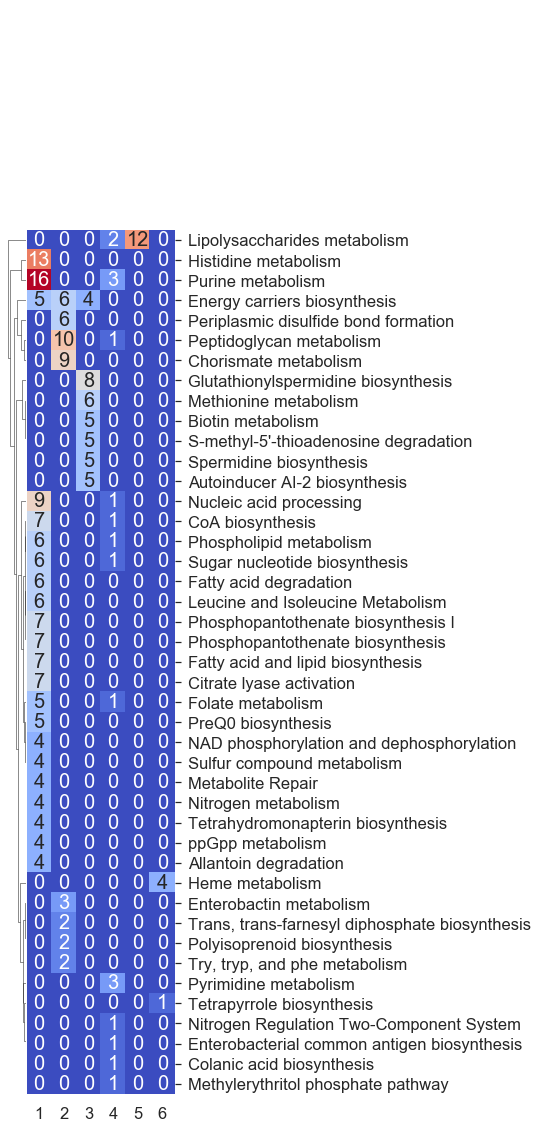

In [24]:
plt.figure()
plt.style.use('seaborn')

# create heatmaps of overlap between genes in each groups
labels = ['1', '2', '3', '4', '5', '6']
sns.set(font_scale=1.5)
g = sns.clustermap(pathway_genes2, row_cluster=True, col_cluster = False, xticklabels = labels, annot = True, cmap = 'coolwarm',  annot_kws={"size": 20}, figsize = (3, 20))
#plt.ylabel('Significant pathway', fontsize = 32)
#plt.xlabel('Cluster', fontsize = 32)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
g.cax.set_visible(False)
#plt.savefig("Figure3B_2_metyieldsGreedy_bothdir.eps", format = 'eps', bbox_inches="tight") 
#plt.savefig("Figure3B_2_metyieldsGreedy_bothdir.svg", format = 'svg', bbox_inches="tight") 
plt.show()

### Heatmap - (Supplementary Figure 4c antibiotics related to each metabolic pathway)

In [25]:
### Get heatmap showing the number of antibiotics associated with each significant pathway

### Get a list of all the significant pathways (grouped)

### need a matrix of number of genes per cluster per sig. pathway - sum the grouped pathways
pathway_ab = pd.DataFrame(index = sig_pathways2)

count = 0
for a in df_AB_all.columns:
    col = [] # col for number of genes in each pathway

    for i in sig_pathways2:
        
        
        
        genes_path = []
        for ind, data in sig_pathways_clusters.items():
            for path, genes in data.items():
                if path == i:
                    for ge in genes:
                        if df_AB_all[a][gene_name_dic[ge]] > 0.0:
                            genes_path.append(ge)
        for ind, data in sig_pathways_clusters40.items():
            for path, genes in data.items():
                if path == i:
                    for ge in genes:
                        if df_AB_all[a][gene_name_dic[ge]] > 0.0:
                            genes_path.append(ge)
                    
                    
                                    
        if i in grouped_sig_pathways.keys():
            for pathway in grouped_sig_pathways[i]:
                for ind, data in sig_pathways_clusters.items():
                    for path, genes in data.items():
                        if pathway == path:
                            for ge in genes:
                                if df_AB_all[a][gene_name_dic[ge]] > 0.0:
                                    genes_path.append(ge)
                                    
                for ind, data in sig_pathways_clusters40.items():
                    for path, genes in data.items():
                        if pathway == path:
                            for ge in genes:
                                if df_AB_all[a][gene_name_dic[ge]] > 0.0:
                                    genes_path.append(ge)
                

                                   
        genes_path = list(set(genes_path))
        #print(a, genes_path) 
        col.append(len(genes_path))
    pathway_ab.insert(count, column = a, value = col)
    count += 1
    

In [35]:
pathway_ab = pathway_ab.rename({'Tyrosine, Tryptophan, and Phenylalanine Metabolism' : 'Try, tryp, and phe metabolism'})
pathway_ab = pathway_ab.rename({'Colanic acid building blocks biosynthesis' : 'Colanic acid biosynthesis'})

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

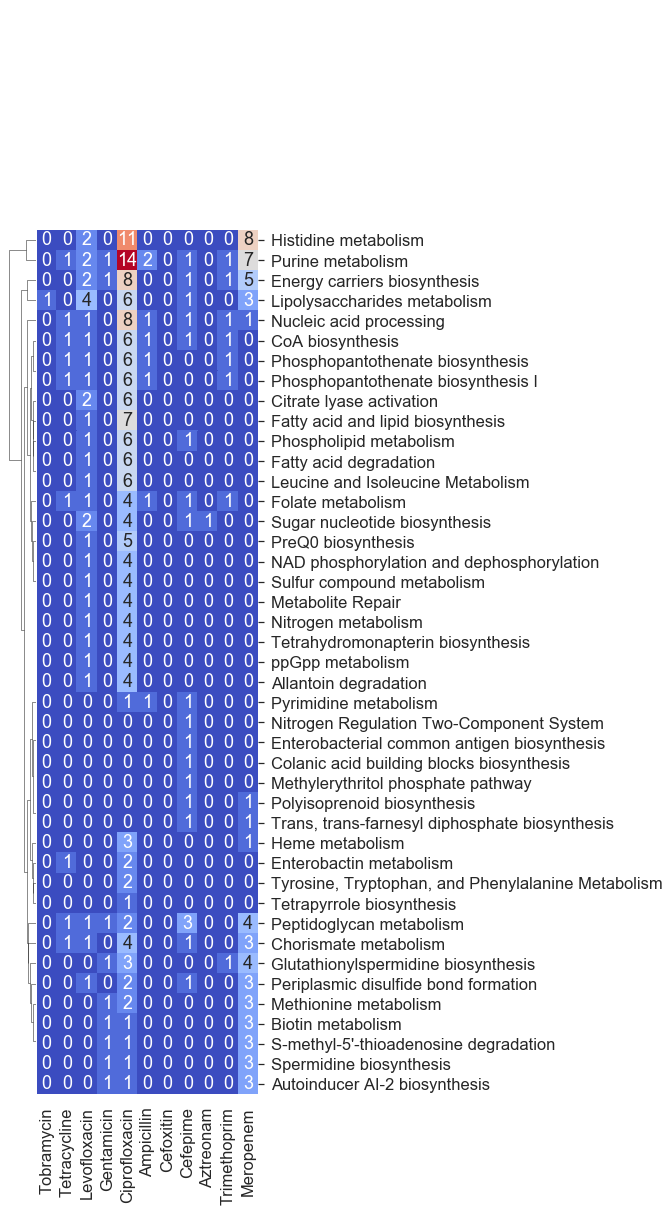

In [26]:
#plt.figure(figsize = (12,10))
plt.style.use('seaborn')

# create heatmaps of overlap between genes in each groups
sns.set(font_scale=1.5)

g = sns.clustergrid = sns.clustermap(pathway_ab, row_cluster = True, col_cluster = False, annot = True, cmap = 'coolwarm', annot_kws={"size": 18},figsize = (4.5, 20))
#plt.ylabel('Antibiotic', fontsize = 32)
#plt.xlabel('Antibiotic', fontsize = 32)
g.cax.set_visible(False)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.savefig("Figure3C_2_metyieldsGreedy_bothdir.eps", format = 'eps', bbox_inches="tight") 
#plt.savefig("Figure3C_2_metyieldsGreedy_bothdir.svg", format = 'svg', bbox_inches="tight") 
plt.show()

In [27]:
### Figure 5 b

In [28]:
# group together some subsystems 
systems = {}
systems['Cell Wall'] =  ['Murein Biosynthesis',
                         'Cell Envelope Biosynthesis', 
                         'Lipopolysaccharide Biosynthesis / Recycling',
                         'Glycerophospholipid Metabolism', 
                         'Murein Recycling',
                            'Membrane Lipid Metabolism']
                        
systems['Nucleotides Metabolism'] = ['Nucleotide Salvage Pathway',
                                     'Folate Metabolism',
                                     'Purine and Pyrimidine Biosynthesis']
                        
systems['Amino Acid Metabolism'] = ['Arginine and Proline Metabolism',
                                    'Valine, Leucine, and Isoleucine Metabolism',
                                    'Tyrosine, Tryptophan, and Phenylalanine Metabolism',
                                    'Alanine and Aspartate Metabolism',
                                    'Histidine Metabolism',
                                    'Cysteine Metabolism',
                                    'Glycine and Serine Metabolism', 
                                    'Threonine and Lysine Metabolism', 
                                   'Glutamate Metabolism', 
                                   'Methionine Metabolism']

systems['Carbohydrate Metabolism'] = ['Anaplerotic Reactions', 
                                     'Citric Acid Cycle',
                                     'Glycolysis/Gluconeogenesis',
                                     'Pyruvate Metabolism',
                                     'Pentose Phosphate Pathway',
                                     'Glyoxylate Metabolism', 
                                     'Methylglyoxal Metabolism']

systems['Transport'] = ['Transport, Outer Membrane Porin', 
                        'Transport, Outer Membrane',
                        'Transport, Inner Membrane']

systems['Alternative Carbon Metabolism'] = ['Alternate Carbon Metabolism']
systems['Cofactor and Prosthetic Group Metabolism'] = ['Cofactor and Prosthetic Group Biosynthesis']
systems['Energy metabolism'] = ['Oxidative Phosphorylation']
systems['Inorganic Transport and Metabolism'] = ['Inorganic Ion Transport and Metabolism']
systems['Nitrogen Metabolism'] = ['Nitrogen Metabolism']








In [29]:
# Create dataframe showing the links between reactions and metabolic systems

reacs = []
for r in m.reactions:
    reacs.append(r.id)
df_reacs_ss_all = pd.DataFrame(index = reacs)

count = 0
for s, subs in systems.items():
 
    s_genes = []
    for r in m.reactions:
        r_s = 0        
        if r.subsystem in subs:

            r_s = 1
        s_genes.append(r_s)
    
    df_reacs_ss_all.insert(count, column = s, value = s_genes)
    count += 1

In [30]:
# get the number of reactions associated to each cluster for each metabolic system
clusters_df = pd.DataFrame(index = list(df_reacs_ss_all))
clusters_include = [0, 1, 2, 3, 4, 5]
count = 0
for ind, i in enumerate(c):
    if ind in clusters_include:
        met_reacs, df_met_reacs = create_met_reacs_dataframe(c[ind], m)
        df_met_ss = df_met_reacs.T.dot(df_reacs_ss_all)
        df_met_ss[df_met_ss> 0] = 1
        clusters_df.insert(count, column = count+1, value = list(df_met_ss.sum().values))
        count += 1

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

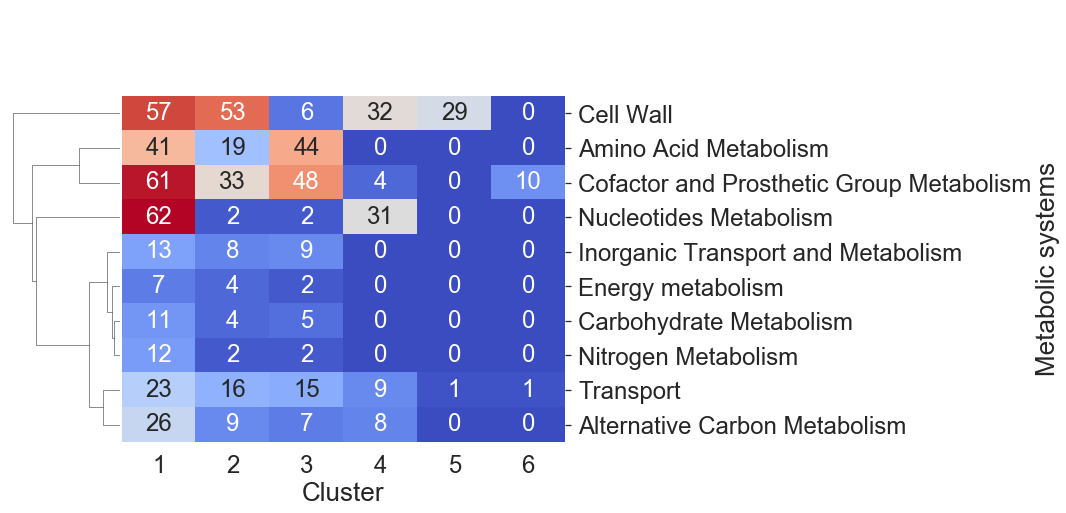

In [31]:
g = sns.clustermap(clusters_df, annot = True, method = 'average', cmap = 'coolwarm', row_cluster=True, col_cluster=False, square=False, figsize = (10,8), annot_kws={"size": 24})
sns.set(font_scale=3.0)
sns.set(font='arial')
plt.xticks(fontsize = 22)
g.ax_heatmap.set_xlabel('Cluster', fontsize = 26)
g.ax_heatmap.set_ylabel('Metabolic systems', fontsize = 26)


g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 24)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 24)
g.cax.set_visible(False)

#plt.savefig('SuppFigureB_GreedyClusters_bothdir.eps', format = 'eps', bbox_inches="tight")
#plt.savefig('SuppFigureB_GreedyClusters_bothdir.svg', format = 'svg', bbox_inches="tight")

In [33]:
### Figure 5c

In [32]:
### Antibiotics in each cluster

# Create dataframe showing the number of genes from each antibiotic in each cluster
df_AB_all_bin = df_AB_all.copy()
df_AB_all_bin[df_AB_all_bin> 0] = 1

df_c_gene = pd.DataFrame(index = genes_ALL)
count = 0
for ind, i in enumerate(c):
    if ind in clusters_include:
        col = []
        
        for node in genes_ALL:
            if gene_name_dic2[node] in c[ind]:
                col.append(1)
            else:
                col.append(0)
        df_c_gene.insert(count, column = count + 1, value = col)
        count += 1
    
df1, df2 = df_AB_all_bin.align(df_c_gene, join='outer', axis=0)  
df_c_ab = df1.T.dot(df2)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

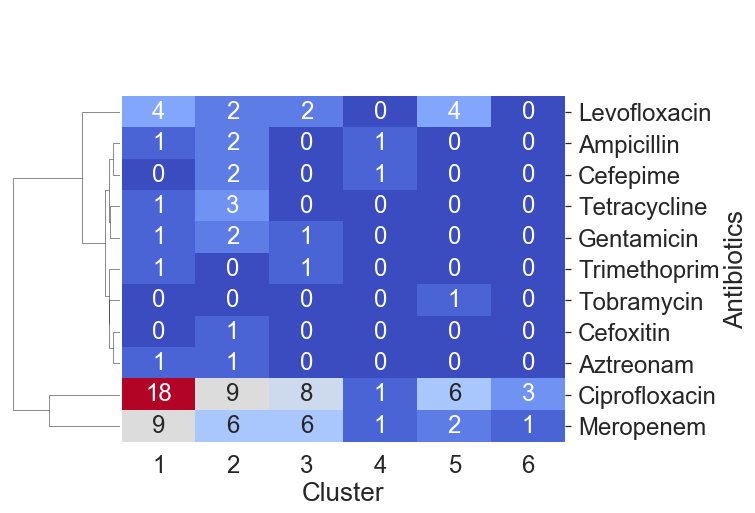

In [34]:
g = sns.clustermap(df_c_ab, annot = True, method = 'average', cmap = 'coolwarm', row_cluster=True, col_cluster=False, square=False, figsize = (10,8), annot_kws={"size": 24})
sns.set(font_scale=3.0)
sns.set(font='arial')
plt.xticks(fontsize = 22)
g.ax_heatmap.set_xlabel('Cluster', fontsize = 26)
g.ax_heatmap.set_ylabel('Antibiotics', fontsize = 26)


g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 24)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 24)
g.cax.set_visible(False)

#plt.savefig('SuppFigureC_GreedyClusters_bothdir.eps', format = 'eps', bbox_inches="tight")
#plt.savefig('SuppFigureC_GreedyClusters_bothdir.svg', format = 'svg', bbox_inches="tight")

In [123]:
### Supplementary Heatmap of all genes in the network - reordered by the clusters

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

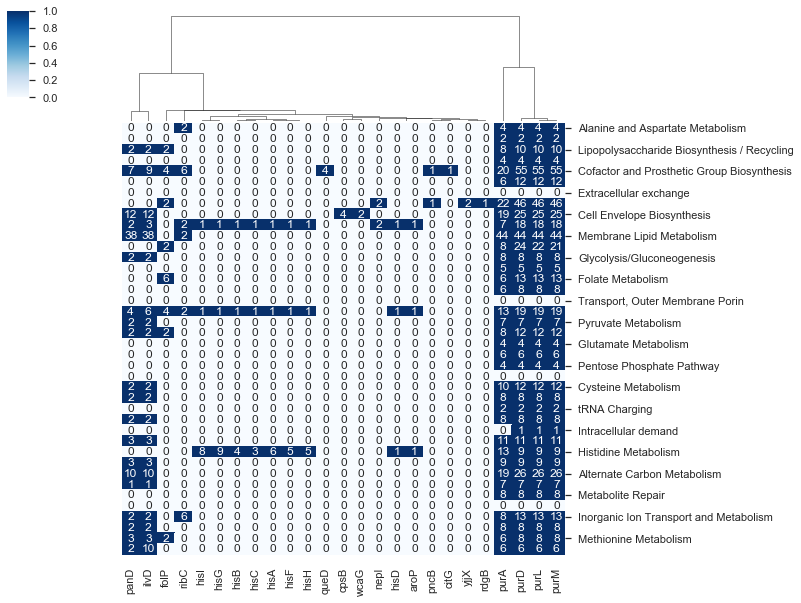

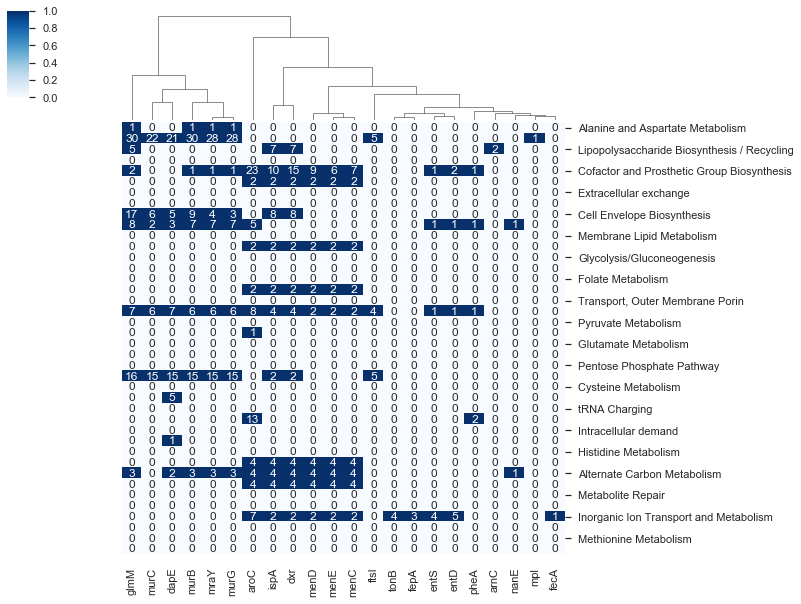

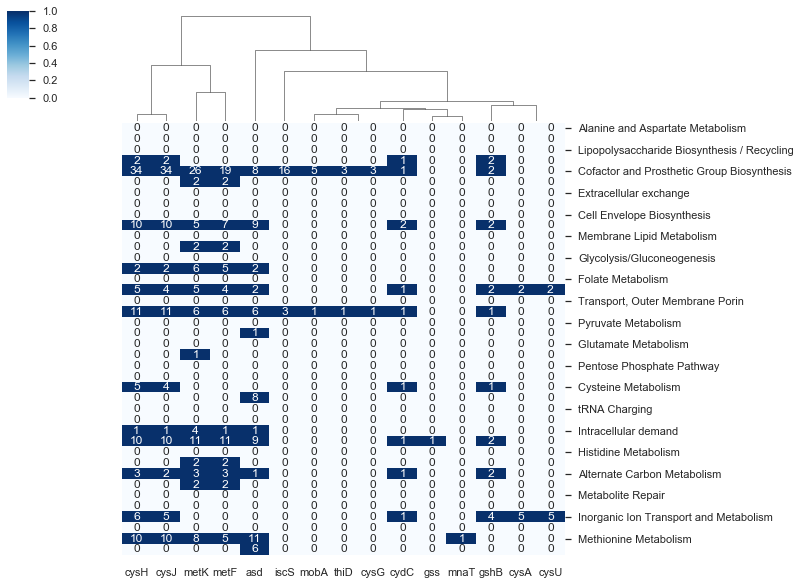

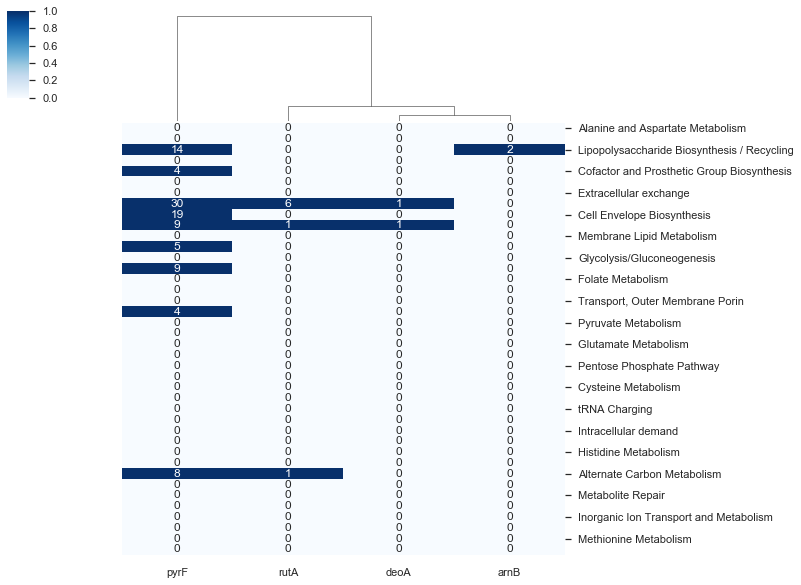

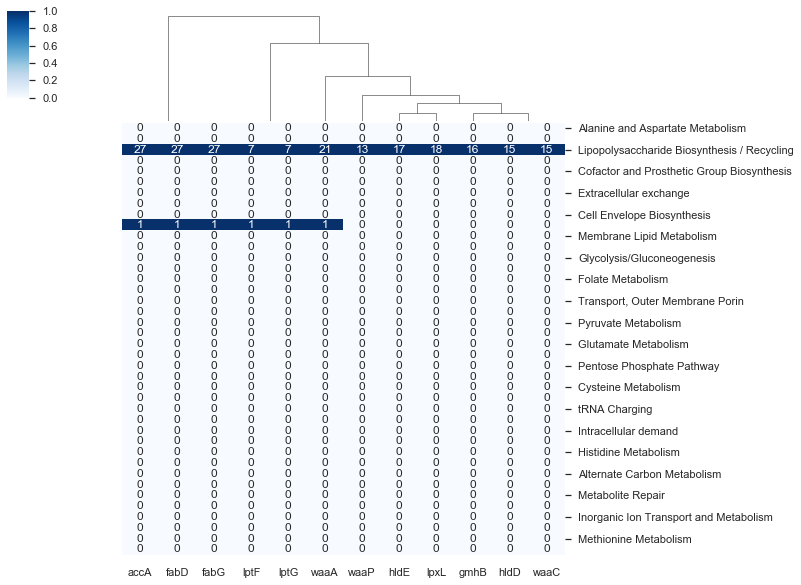

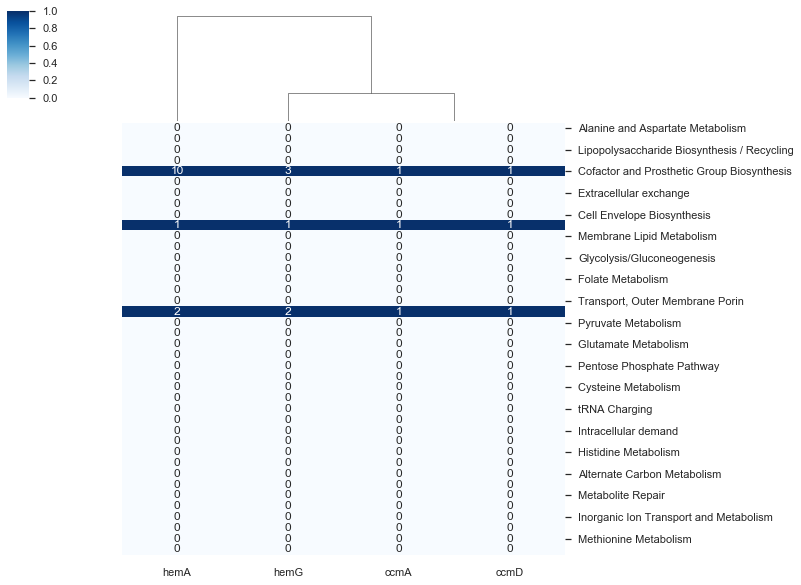

In [35]:
# The heatmap of all genes but ordered by the clusters they are in and similar to

gene_order = {}
df_genes_sss_c = {}

clusters_dfs = {}
for ind, nodes in enumerate(c[:6]):
    nodes2_c = []
    for node in nodes:
        if node in nodes2:
            nodes2_c.append(node)
    met_reacs, df_met_reacs = create_met_reacs_dataframe(nodes2_c, m)
    df_met_sss = df_met_reacs.T.dot(df_reacs_sss_all)
    df_met_sss[df_met_sss> 0] = 1
    clusters_dfs[ind] = df_met_sss # get the metabolite vs subsystems dataframe for each cluster (i.e. 1 if the metabolite is involved in the subsystem)
    


# make a dataframe containing edges 
for clusterID, nodes in enumerate(c[:6]):


    nodes_c = []
    for i in nodes:
        if i + '_c' in m.metabolites or i + '_p' in m.metabolites:
            nodes_c.append(i)
    nodes_c = list(set(nodes_c)) # list of metabolites nodes in the cluster

    df_met_genes_c = pd.DataFrame(index = nodes_c)

    count = 0
    for ind, i in enumerate(nodes1):
        col = []
        if i in c[clusterID]:
            for indj, j in enumerate(nodes_c):
                if (i, j) in edges:
                    col.append(1)
                else:
                    col.append(0)
            df_met_genes_c.insert(count, column = i, value = col) # create a dataframe for the individual cluster showing the relationship between genes and metabolites (i.e. if a gene blocked the metabolites production)
            count += 1



    df_genes_sss = df_met_genes_c.T.dot(clusters_dfs[clusterID]) # get the dataframe showing the number of metabolites effected in each subsystem by the gene
    df_genes_sss_c[clusterID] = df_genes_sss



    g = sns.clustermap(df_genes_sss.T, annot = True, cmap='Blues', row_cluster=False, col_cluster=True, vmin=0, vmax=1)
    

    # add gene ID order for each cluster
    gene_order[clusterID] = g.dendrogram_col.dendrogram['leaves']

In [36]:
# Get DataFrame of all genes and metabolites in the network 
df_met_genes_all = pd.DataFrame(index = nodes2)

count = 0
for ind, i in enumerate(nodes1):
    col = []
    for j in nodes2:
        if (i, j) in edges:
            col.append(1)
        else:
            col.append(0)
    df_met_genes_all.insert(count, column = i, value = col)
    count += 1
    


met_reacs_all, df_met_reacs_all = create_met_reacs_dataframe(nodes2, m)
df_met_sss_all = df_met_reacs_all.T.dot(df_reacs_sss_all)
df_met_sss_all[df_met_sss_all> 0] = 1

In [37]:
df_genes_sss_all = df_met_genes_all.T.dot(df_met_sss_all)

In [38]:
# Get DataFrame of genes vs subsystems reordered by the genes in each cluster (and according to how similar the genes are to each other in terms of phenotype)

gene_order_full = []
gene_order_full = list(df_genes_sss_c[0].T.columns[gene_order[0]])
for i, j in gene_order.items():
    if i > 0:
        gene_order_full = gene_order_full + list(df_genes_sss_c[i].T.columns[j])
        
df_genes_sss = df_met_genes_all.T.dot(df_met_sss_all)
df_genes_sss_reorder = df_genes_sss.T.reindex(columns=gene_order_full)

[Text(0.5, 0, 'panD'),
 Text(1.5, 0, 'ilvD'),
 Text(2.5, 0, 'folP'),
 Text(3.5, 0, 'ribC'),
 Text(4.5, 0, 'hisI'),
 Text(5.5, 0, 'hisG'),
 Text(6.5, 0, 'hisB'),
 Text(7.5, 0, 'hisC'),
 Text(8.5, 0, 'hisA'),
 Text(9.5, 0, 'hisF'),
 Text(10.5, 0, 'hisH'),
 Text(11.5, 0, 'queD'),
 Text(12.5, 0, 'cpsB'),
 Text(13.5, 0, 'wcaG'),
 Text(14.5, 0, 'nepI'),
 Text(15.5, 0, 'hisD'),
 Text(16.5, 0, 'aroP'),
 Text(17.5, 0, 'pncB'),
 Text(18.5, 0, 'citG'),
 Text(19.5, 0, 'yjjX'),
 Text(20.5, 0, 'rdgB'),
 Text(21.5, 0, 'purA'),
 Text(22.5, 0, 'purD'),
 Text(23.5, 0, 'purL'),
 Text(24.5, 0, 'purM'),
 Text(25.5, 0, 'glmM'),
 Text(26.5, 0, 'murC'),
 Text(27.5, 0, 'dapE'),
 Text(28.5, 0, 'murB'),
 Text(29.5, 0, 'mraY'),
 Text(30.5, 0, 'murG'),
 Text(31.5, 0, 'aroC'),
 Text(32.5, 0, 'ispA'),
 Text(33.5, 0, 'dxr'),
 Text(34.5, 0, 'menD'),
 Text(35.5, 0, 'menE'),
 Text(36.5, 0, 'menC'),
 Text(37.5, 0, 'ftsI'),
 Text(38.5, 0, 'tonB'),
 Text(39.5, 0, 'fepA'),
 Text(40.5, 0, 'entS'),
 Text(41.5, 0, 'entD'),
 Te

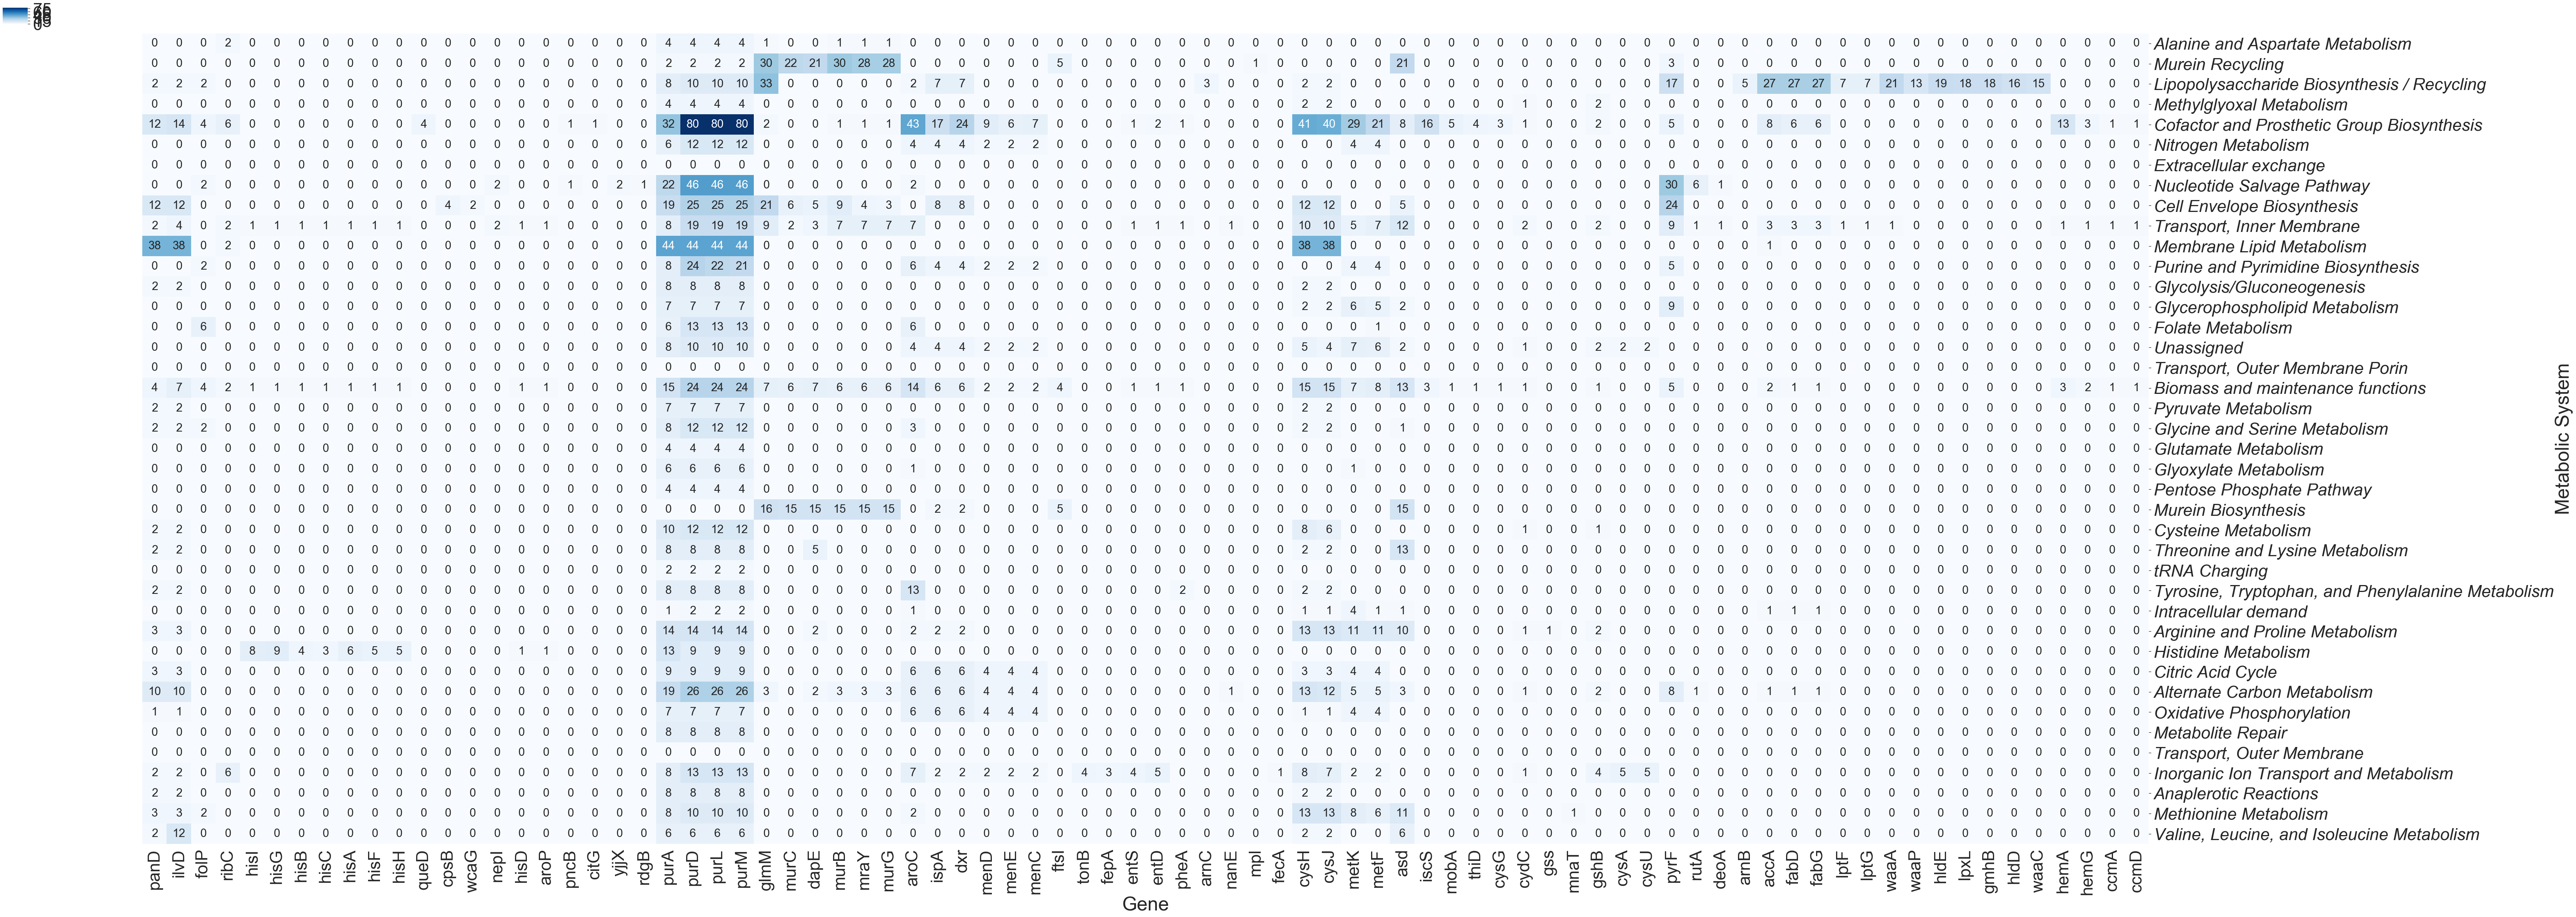

In [39]:
# plot as a heatmap
sns.set(font_scale=4.0)

g = sns.clustermap(df_genes_sss_reorder, annot = True, cmap='Blues', row_cluster=False
, col_cluster=False, figsize = (100, 40), annot_kws={"size": 30}, fmt = 'd')

g.ax_heatmap.set_xlabel('Gene', fontsize = 50)
g.ax_heatmap.set_ylabel('Metabolic System', fontsize = 50)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontstyle = ("italic"))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), rotation = 90)



#plt.savefig('SuppFig5_bothdir.eps', format = 'eps', bbox_inches="tight")
#plt.savefig('SuppFig5_bothdir.svg', format = 'svg', bbox_inches="tight")